<a href="https://colab.research.google.com/github/ItaloNardy/NetworkAnalysis_U3/blob/main/ProjU3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports
!pip install pyvis python-louvain networkx pandas matplotlib seaborn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from IPython.display import display, HTML
import tempfile
import os

# Try Louvain and Pyvis
try:
    import community as community_louvain
except ImportError:
    !pip install python-louvain
    import community as community_louvain

try:
    from pyvis.network import Network
except ImportError:
    !pip install pyvis
    from pyvis.network import Network

In [10]:
# Load dataset
url = "https://raw.githubusercontent.com/ItaloNardy/NetworkAnalysis_U3/refs/heads/main/marvel-unimodal-edges.csv"
df = pd.read_csv(url)

# Ensure required columns
if not {'Source', 'Target', 'Weight'}.issubset(df.columns):
    raise ValueError("CSV must contain 'Source', 'Target', and 'Weight' columns.")

# Edge limit input
default_limit = 500
edge_limit = input(f"Enter number of edges to display (default={default_limit}): ").strip()
if not edge_limit.isdigit():
    edge_limit = default_limit
else:
    edge_limit = int(edge_limit)

df = df.head(edge_limit)
print(f"Displaying first {edge_limit} edges.")


Enter number of edges to display (default=500): 500
Displaying first 500 edges.


In [11]:
# Build NetworkX graph
G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr='Weight')
partition = community_louvain.best_partition(G)
degree_dict = dict(G.degree())
max_degree = max(degree_dict.values()) if degree_dict else 1

# Color palette
palette = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
    "#008080", "#e6beff", "#9a6324", "#fffac8", "#800000"
]


In [15]:
# Pyvis network
net = Network(height='900px', width='100%', notebook=True, cdn_resources='in_line')

for node in G.nodes():
    community_id = partition.get(node, 0)
    degree = degree_dict.get(node, 1)
    size = 15 + (degree / max_degree) * 35
    color = palette[community_id % len(palette)]

    net.add_node(
        node,
        label=node,
        title=f"Community: {community_id}\nDegree: {degree}",
        color=color,
        size=size,
        shape="dot"
    )

for _, row in df.iterrows():
    net.add_edge(row['Source'], row['Target'], value=row['Weight'])

net.show_buttons(filter_=['physics'])


In [16]:
# Save and display interactive network in notebook
with tempfile.NamedTemporaryFile(delete=False, suffix=".html") as tmp_file:
    path = tmp_file.name
    net.save_graph(path)

display(HTML(filename=path))


In [18]:
# Network Analysis
if nx.is_connected(G):
    G_connected = G
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_connected = G.subgraph(largest_cc).copy()
    print("Graph not connected. Using largest connected component.")

# Adjacency matrix
adj_matrix = nx.adjacency_matrix(G_connected)
adj_df = pd.DataFrame(adj_matrix.todense(), index=G_connected.nodes(), columns=G_connected.nodes())
display(adj_df)


,Black Panther / T'chal,Loki [asgardian],Mantis / ? Brandt,Iceman / Robert Bobby,Marvel Girl / Jean Grey,Cyclops / Scott Summer,Klaw / Ulysses Klaw,Human Torch / Johnny S,"Richards, Franklin B",Wolverine / Logan,...,Sunspot / Roberto Daco,Firefist / Rusty Colli,Bishop /,Daytripper / Amanda Se,Wild Child / Kyle Gibn,Thunderbird Ii / James,Sauron / Dr. Karl Lyko,Siryn / Theresa Rourke,Shatterstar Ii / Gavee,Marrow / Sarah
Black Panther / T'chal,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Loki [asgardian],1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mantis / ? Brandt,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Iceman / Robert Bobby,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Marvel Girl / Jean Grey,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thunderbird Ii / James,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sauron / Dr. Karl Lyko,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Siryn / Theresa Rourke,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shatterstar Ii / Gavee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Diameter
diameter = nx.diameter(G_connected)
print(f"Network Diameter: {diameter}")

# Periphery
periphery_nodes = list(nx.periphery(G_connected))
print(f"Periphery Nodes ({len(periphery_nodes)}):")
print(periphery_nodes)

# Density
density = nx.density(G_connected)
print(f"Density: {density:.5f}, Sparsity: {(1 - density):.5f}")

# Assortativity
try:
    assortativity = nx.degree_assortativity_coefficient(G_connected)
    print(f"Degree Assortativity Coefficient: {assortativity:.5f}")
except nx.NetworkXError as e:
    print(f"Assortativity error: {e}")

Network Diameter: 4
Periphery Nodes (39):
['Klaw / Ulysses Klaw', 'Lyja Lazerfist [skru', 'Lizard / Dr. Curtis Co', 'Volcana / Marsha Rosen', 'Lockheed', 'Titania Ii / Mary Skee', 'Boomer / Tabitha Smith', 'Summers, Nathan Chri', 'Summers, Madelyne Ma', 'Mactaggert, Moira Ki', 'Cannonball Ii / Sam Gu', 'Tilby, Trish / Patrici', 'Skids / Sally Blevins', 'Wolfsbane / Rahne Sinc', 'Leech', 'Mirage Ii / Danielle M', 'Gambit / Remy Lebeau', 'Jubilee / Jubilation L', 'Strong Guy / Guido Car', 'Spiral', 'Banshee / Sean Cassidy', 'Legion Ii / David Hall', 'Havok / Alex Summers', 'Longshot', 'Forge', 'Sabretooth / Victor Cr', 'Maddicks, Arthur Art', 'Warlock Iii', 'Rictor / Julio Esteban', 'Sunspot / Roberto Daco', 'Firefist / Rusty Colli', 'Bishop  / ', 'Daytripper / Amanda Se', 'Wild Child / Kyle Gibn', 'Thunderbird Ii / James', 'Sauron / Dr. Karl Lyko', 'Siryn / Theresa Rourke', 'Shatterstar Ii / Gavee', 'Marrow / Sarah']
Density: 0.01701, Sparsity: 0.98299
Degree Assortativity Coefficient: 

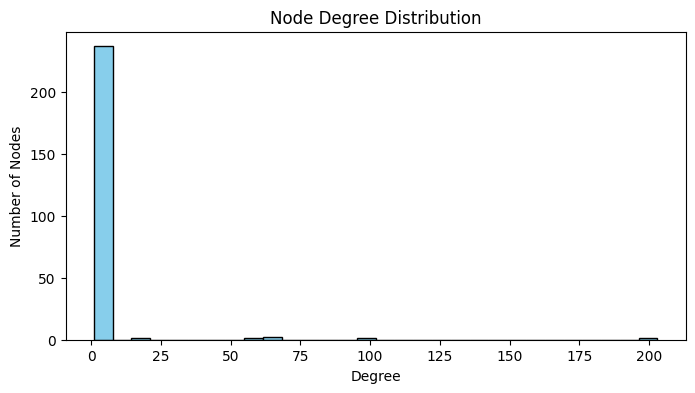

In [20]:
# Degree histogram
degrees = [deg for _, deg in G_connected.degree()]
plt.figure(figsize=(8,4))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()


In [24]:
# Centrality measures
eigen = nx.eigenvector_centrality(G_connected, max_iter=1000)
degree = nx.degree_centrality(G_connected)
closeness = nx.closeness_centrality(G_connected)
betweenness = nx.betweenness_centrality(G_connected)

centrality_df = pd.DataFrame({
    'Node': list(G_connected.nodes()),
    'Eigenvector': [eigen[n] for n in G_connected.nodes()],
    'Degree': [degree[n] for n in G_connected.nodes()],
    'Closeness': [closeness[n] for n in G_connected.nodes()],
    'Betweenness': [betweenness[n] for n in G_connected.nodes()]
})

# Display top 10 nodes per metric in descending order
top_k = 10

for metric in ['Eigenvector', 'Degree', 'Closeness', 'Betweenness']:
    print(f"\nTop {top_k} nodes by {metric} centrality:")
    print(centrality_df[['Node', metric]].sort_values(by=metric, ascending=False).head(top_k).reset_index(drop=True))



Top 10 nodes by Eigenvector centrality:
                     Node  Eigenvector
0   Iron Man / Tony Stark     0.537922
1  Black Panther / T'chal     0.339432
2  Iron Man Iv / James R.     0.231967
3    Blob / Fred J. Dukes     0.199181
4  Mystique / Raven Darkh     0.168881
5  Pyro / Allerdyce Johnn     0.080542
6  Nightcrawler / Kurt Wa     0.079842
7   Scarlet Witch / Wanda     0.079842
8  Storm / Ororo Munroe S     0.079842
9     Gyrich, Henry Peter     0.079842

Top 10 nodes by Degree centrality:
                     Node    Degree
0   Iron Man / Tony Stark  0.838843
1  Black Panther / T'chal  0.417355
2  Iron Man Iv / James R.  0.268595
3    Blob / Fred J. Dukes  0.256198
4  Mystique / Raven Darkh  0.239669
5  Pyro / Allerdyce Johnn  0.078512
6  Nightcrawler / Kurt Wa  0.020661
7       Wolverine / Logan  0.020661
8  Storm / Ororo Munroe S  0.020661
9     Gyrich, Henry Peter  0.020661

Top 10 nodes by Closeness centrality:
                     Node  Closeness
0   Iron Man / Tony St

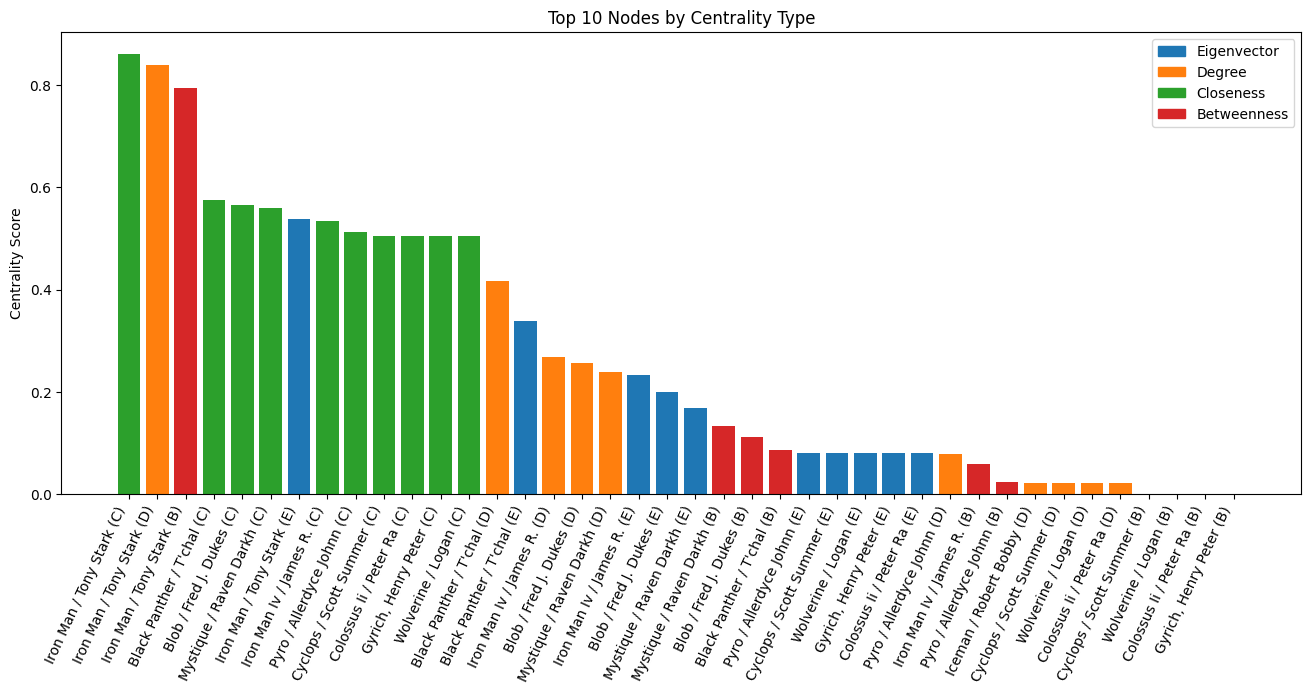

In [25]:
# Plot Top 10 per centrality
top_k = 10
label_map = {'Eigenvector': 'E', 'Degree': 'D', 'Closeness': 'C', 'Betweenness': 'B'}
color_map = {
    'Eigenvector': '#1f77b4',
    'Degree': '#ff7f0e',
    'Closeness': '#2ca02c',
    'Betweenness': '#d62728'
}

melted = centrality_df.melt(id_vars='Node', var_name='Type', value_name='Score')
top_nodes = pd.concat([melted[melted['Type'] == t].nlargest(top_k, 'Score') for t in label_map])
top_nodes = top_nodes.sort_values("Score", ascending=False)

labels = [f"{row['Node']} ({label_map[row['Type']]})" for _, row in top_nodes.iterrows()]
scores = top_nodes['Score'].tolist()
colors = [color_map[row['Type']] for _, row in top_nodes.iterrows()]

plt.figure(figsize=(16, 6))
plt.bar(labels, scores, color=colors)
plt.xticks(rotation=65, ha='right')
plt.ylabel("Centrality Score")
plt.title("Top 10 Nodes by Centrality Type")
handles = [plt.Rectangle((0,0),1,1,color=color_map[t], label=t) for t in color_map]
plt.legend(handles=handles)
plt.show()
